In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums,ttest_1samp,spearmanr
from scipy.signal import find_peaks

from nilearn.image import load_img, new_img_like
from nilearn.plotting import plot_img_on_surf

from scipy.spatial.distance import cdist
import rle
import awkward as ak


In [2]:
maxrois = pd.read_csv('/home/joyneelm/emoprox2_slds_bootstrap_resamples/README_MAX_ROIs_final_gm_85.txt',sep='\t')

In [3]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

Index(['pid', 'rid', 'block', 'timeseries', 'proximity', 'direction', 'speed',
       'time', 'proximity_hrf', 'direction_hrf', 'speed_hrf', 'censor',
       'block_mask', 'input'],
      dtype='object')
(133,)
55


Text(0, 0.5, 'frequency')

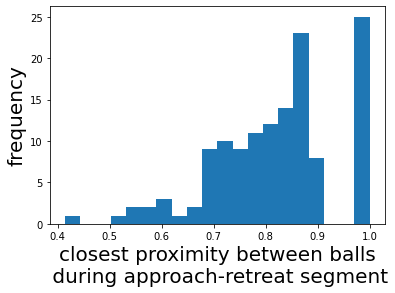

In [4]:
pid_df = orig_df[orig_df.pid=='002']
print(pid_df.columns)
allpeaks = []
for idx_row,row in pid_df.iterrows():
    prox = row['proximity']
    prox = prox/np.max(prox)
    idx_peaks,_ = find_peaks(prox)
    allpeaks.append(prox[idx_peaks])
fig = plt.figure()
allpeaks = np.hstack(allpeaks)
print(allpeaks.shape)
print(((allpeaks>0.8)&(allpeaks<0.9)).sum())
plt.hist(allpeaks,bins=20)
plt.xlabel('closest proximity between balls\n during approach-retreat segment',fontsize=20)
plt.ylabel('frequency',fontsize=20)

In [5]:
K = 6
D = 10
N = 85
num_subjs = 92
M=20
num_resamples = 500

In [6]:
all_dfs, all_models, state_masks = {}, {}, {}
for l in range(1,500,50):
    r = l + 49
    with open(f'pkl/all_dicts_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples_l={l}_r={r}_allfactors.pkl','rb') as f:
        all_dfs1,all_models1,state_masks1 = pickle.load(f)

    all_dfs.update(all_dfs1)
    all_models.update(all_models1)
    state_masks.update(state_masks1)

In [7]:
print(len(all_dfs),len(all_models),len(state_masks))

500 500 500


In [8]:
all_dfs[1]['input'].values[0].shape

(147, 20)

# ROI importances

In [9]:
# for df,model,state_mask in tqdm(zip(all_dfs.values(),all_models.values(),state_masks.values())):
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     Vs = model.dynamics.Vs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     Cinv = np.linalg.pinv(C) 
#     Vhat_statewise = np.zeros((K,N,M))
#     Ahat_statewise = np.zeros((K,N,N))
#     for idx_state in range(K):
#         # y_{t} = C x_{t} + d
#         # x_{t+1} = A x_{t} + b
#         # y_{t+1} = C x_{t+1} + d = C (A x_{t} + b) + d = C A Cinv y_{t} + C b + d
#         Ahat_statewise[idx_state,:,:] = C@As[idx_state]@Cinv
#         Vhat_statewise[idx_state,:,:] = C@Vs[idx_state] 

#     identity = np.eye(N)
#     df['roi_importance'] = [None]*df.shape[0]
#     for idx_row,row in df.iterrows():
#         y = row['timeseries']
#         z = row['discrete_states']
#         u = np.argmax(row['input'],axis=1)
#         roi_importance = np.zeros_like(y)
#         for idx_roi in range(N):
#             for t in range(y.shape[0]):
#                 roi_importance[t,idx_roi] = np.linalg.norm(y[t,idx_roi]*Ahat_statewise[z[t],:,idx_roi]+identity[:,idx_roi]*Vhat_statewise[z[t],idx_roi,u[t]])
#         df.at[idx_row,'roi_importance'] = roi_importance


In [10]:
    # Ahat_columnnorm_shuffled = Ahat_columnnorm.copy()
    # Ahat_columnnorm_shuffled = Ahat_columnnorm_shuffled[:,np.random.permutation(N)]

    # df['roi_importance'] = [None]*df.shape[0]
    # df['null_roi_importance'] = [None]*df.shape[0]
    # for idx_row,row in df.iterrows():
    #     y = row['timeseries']
    #     z = row['discrete_states']

    #     df.at[idx_row,'roi_importance'] = np.multiply(abs(y),Ahat_columnnorm[z,:])
    #     df.at[idx_row,'null_roi_importance'] = np.multiply(abs(y),Ahat_columnnorm_shuffled[z,:])

In [11]:
state_resps = {k:[] for k in range(K)}
state_bold = {k:[] for k in range(K)}
null_state_resps = {k:[] for k in range(K)}
for idx_resample in tqdm(range(1,101)):
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    for idx_row,row in df.iterrows():
        y = row['roi_importance'].copy()
        y -= np.expand_dims(np.mean(y,axis=0),axis=0)
        y /= np.expand_dims(np.std(y,axis=0),axis=0)

        bold = row['timeseries']
        
        z = row['discrete_states'].copy()
        states,durations = rle.encode(z)
        onsets = np.cumsum(np.concatenate((np.zeros(1),durations)))[:-1].astype('int')
        for state,onset,duration in zip(states,onsets,durations):
            if state_mask[state]==1: continue
            state_resps[state].append(y[onset:onset+duration,:])
            state_bold[state].append(bold[onset:onset+duration,:])


100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


In [12]:
mean_imps_all_states = []
mean_bold_all_states = []
for idx_state in range(K-1):
    dur = int(np.mean([y.shape[0] for y in state_resps[idx_state]]))
    mean_imps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
    mean_bold = ak.to_numpy(ak.mean(ak.Array(state_bold[idx_state]),axis=0))[:dur,:]
    mean_imps_all_states.append(mean_imps)
    mean_bold_all_states.append(mean_bold)

(6,)
(5,)
(16,)
(11,)
(6,)


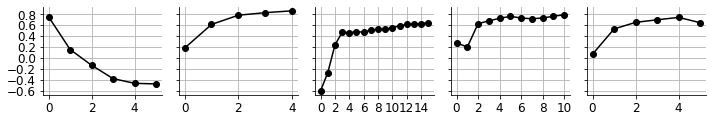

In [13]:
fig,axs = plt.subplots(1,K-1, figsize=(10,1.8),sharey=True)
for idx_state in range(K-1):
    mean_imps = mean_imps_all_states[idx_state]
    mean_bold = mean_bold_all_states[idx_state]
    dur = mean_imps.shape[0]
    corr_ts = np.zeros(dur)
    for t in range(dur):
        corr_ts[t] = spearmanr(mean_imps[t,:],mean_bold[t,:]).statistic
    print(corr_ts.shape)
    ax = axs[idx_state]
    ax.plot(corr_ts,marker='o',color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    # ax.set_title(f'State{idx_state+1}',fontsize=15)
    ax.set_yticks(np.arange(-0.6,1,0.2))
    ax.set_xticks(np.arange(0,dur,2))
    ax.tick_params(axis='both', which='major', labelsize=12)


fig.tight_layout()
fig.savefig(f'figures/fig_importance_BOLD_correlation_K{K}.png',dpi=600,bbox_inches='tight')

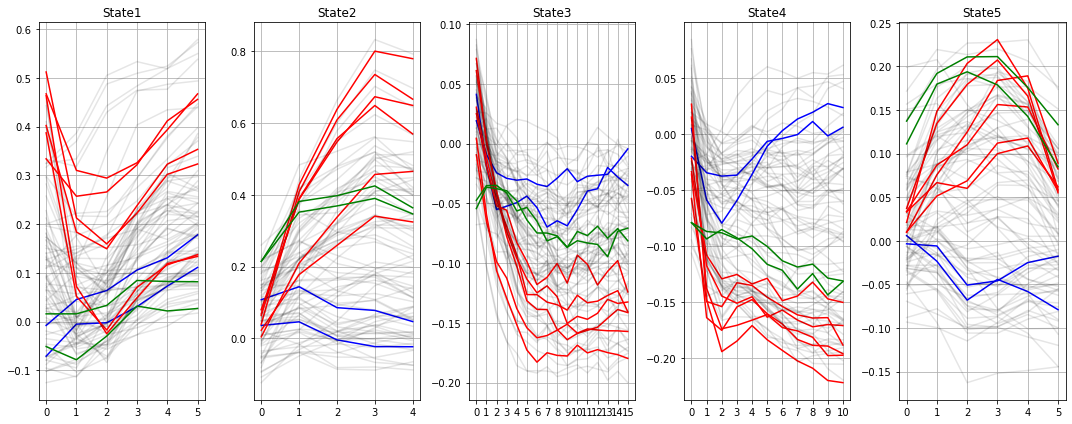

In [14]:
fig,axs = plt.subplots(1,K-1, figsize=(15,6))
for idx_state in range(K-1):
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]

    ax = axs[idx_state]
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "Insula" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='r',alpha=1)
        elif  "vmPFC" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='b',alpha=1)
        elif  "PAG" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='g',alpha=1)
        else:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='k',alpha=0.1)
            
    ax.set_title(f'State{idx_state+1}')
    ax.grid(True)
    ax.set_xticks(np.arange(dur))
fig.tight_layout()

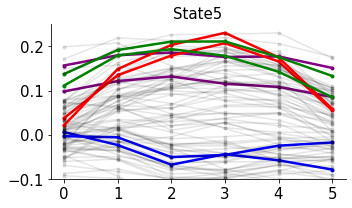

In [15]:
from matplotlib.pyplot import figlegend


fig,axs = plt.subplots(1,1, figsize=(5,3))
lines = []
labels = []
for idx_state in [4]:
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]
    linewidth = 2.5
    ax = axs
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "dorsal Insula" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=row['Hemi']+' '+'dors. ant. Insula',marker='.',color='r',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append(row['Hemi']+' '+'dorsal anterior Insula')
        elif  "vmPFC" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='b',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append("ventromedial PFC"+roi[-1])
        elif  "PAG" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='g',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append(row['Hemi']+' '+"Periaqueductal Gray")
        elif  "post. Caudate" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='purple',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append(row['Hemi']+' '+'posterior Caudate')
        else:
            _ = ax.plot(mean_resps[:,idx_roi],marker='.',color='k',alpha=0.1)
            
    ax.set_title(f'State{idx_state+1}')
    # ax.grid(True)
    ax.set_xticks(np.arange(dur))
    ax.set_ylim([-0.1,0.25])
    ax.set_title(f'State{idx_state+1}',fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # ax.legend()

fig.tight_layout()
fig.savefig(f'figures/fig_state5_importance_K{K}.png',dpi=600,bbox_inches='tight')



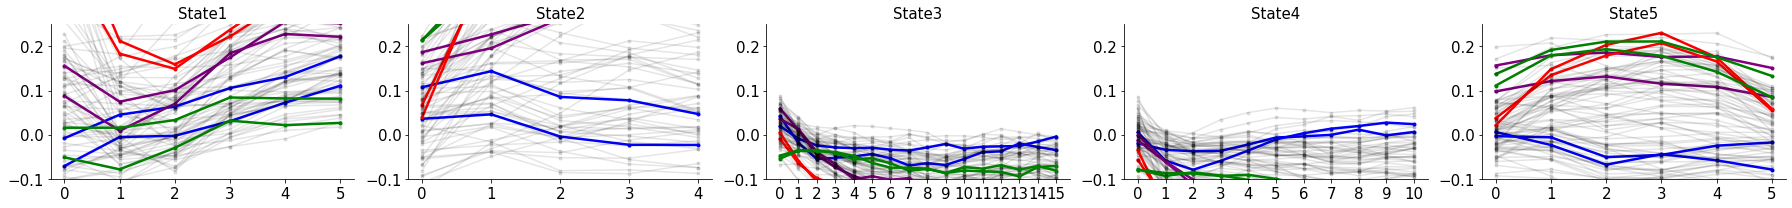

In [47]:
from matplotlib.pyplot import figlegend


fig,axs = plt.subplots(1,5, figsize=(25,3))
lines = []
labels = []
for idx_state in [0,1,2,3,4]:
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]
    linewidth = 2.5
    ax = axs[idx_state]
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "dorsal Insula" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=row['Hemi']+' '+'dors. ant. Insula',marker='.',color='r',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append(row['Hemi']+' '+'dorsal anterior Insula')
        elif  "vmPFC" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='b',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append("ventromedial PFC"+roi[-1])
        elif  "PAG" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='g',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append(row['Hemi']+' '+"Periaqueductal Gray")
        elif  "post. Caudate" in roi:
            line = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='purple',alpha=1,linewidth=linewidth)
            if len(lines)==0: lines = line
            else: lines += line
            labels.append(row['Hemi']+' '+'posterior Caudate')
        else:
            _ = ax.plot(mean_resps[:,idx_roi],marker='.',color='k',alpha=0.1)
            
    ax.set_title(f'State{idx_state+1}')
    # ax.grid(True)
    ax.set_xticks(np.arange(dur))
    # ax.set_ylim([-0.1,0.25])
    ax.set_title(f'State{idx_state+1}',fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # ax.legend()

fig.tight_layout()
fig.savefig(f'figures/fig_state5_importance_all_states.png',dpi=600,bbox_inches='tight')



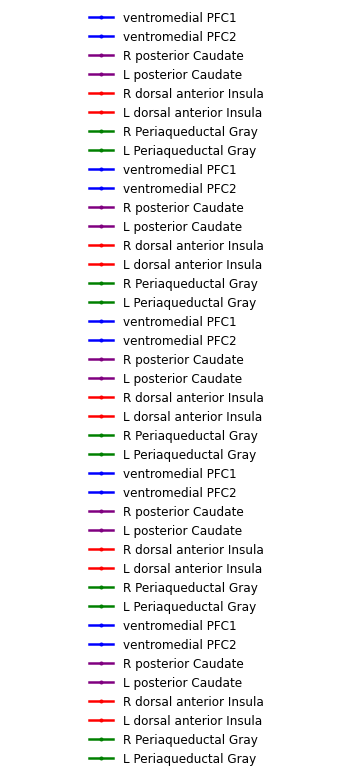

In [48]:
fig_legend,axlegend = plt.subplots(1,1, figsize=(5,3))
fig_legend.legend(lines, labels, loc='center', frameon=False,fontsize=12)
axlegend.spines['top'].set_visible(False)
axlegend.spines['bottom'].set_visible(False)
axlegend.spines['left'].set_visible(False)
axlegend.spines['right'].set_visible(False)
axlegend.set_xticks([])
axlegend.set_yticks([])
fig_legend.tight_layout()
fig_legend.savefig(f'figures/fig_legend_state5_importance_K{K}.png',dpi=600,bbox_inches='tight')


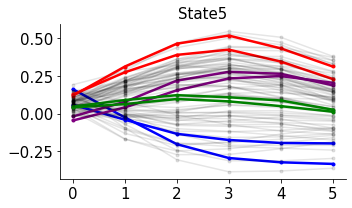

In [49]:
fig,axs = plt.subplots(1,1, figsize=(5,3))
for idx_state in [4]:
    mean_resps = mean_bold_all_states[idx_state]
    dur = mean_resps.shape[0]
    linewidth = 2.5
    ax = axs
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "dorsal Insula" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='r',alpha=1,linewidth=linewidth)
        elif  "vmPFC" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='b',alpha=1,linewidth=linewidth)
        elif  "PAG" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='g',alpha=1,linewidth=linewidth)
        elif  "post. Caudate" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='purple',alpha=1,linewidth=linewidth)
        else:
            _ = ax.plot(mean_resps[:,idx_roi],marker='.',color='k',alpha=0.1)
            
    ax.set_title(f'State{idx_state+1}')
    # ax.grid(True)
    ax.set_xticks(np.arange(dur))
    # ax.set_ylim([-0.1,0.25])
    ax.set_title(f'State{idx_state+1}',fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # ax.legend()

fig.tight_layout()
fig.savefig(f'figures/fig_state5_bold_K{K}.png',dpi=600,bbox_inches='tight')

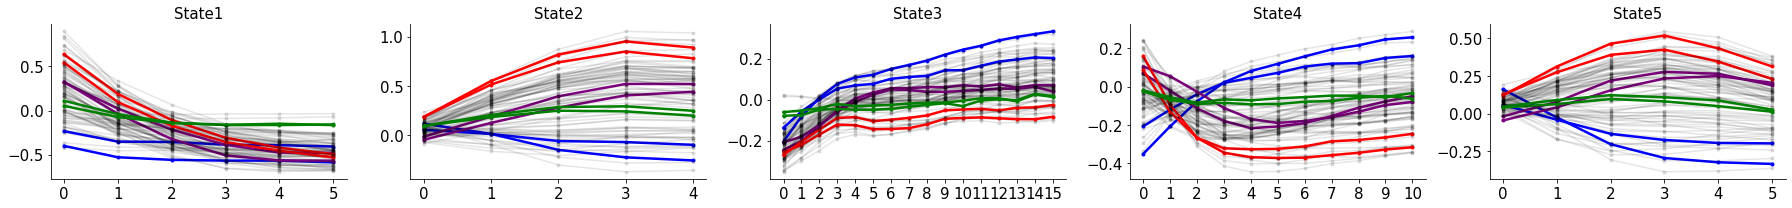

In [50]:
fig,axs = plt.subplots(1,5, figsize=(25,3))
for idx_state in [0,1,2,3,4]:
    mean_resps = mean_bold_all_states[idx_state]
    dur = mean_resps.shape[0]
    linewidth = 2.5
    ax = axs[idx_state]
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "dorsal Insula" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='r',alpha=1,linewidth=linewidth)
        elif  "vmPFC" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='b',alpha=1,linewidth=linewidth)
        elif  "PAG" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='g',alpha=1,linewidth=linewidth)
        elif  "post. Caudate" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='purple',alpha=1,linewidth=linewidth)
        else:
            _ = ax.plot(mean_resps[:,idx_roi],marker='.',color='k',alpha=0.1)
            
    ax.set_title(f'State{idx_state+1}')
    # ax.grid(True)
    ax.set_xticks(np.arange(dur))
    # ax.set_ylim([-0.1,0.25])
    ax.set_title(f'State{idx_state+1}',fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # ax.legend()

fig.tight_layout()
fig.savefig(f'figures/fig_state5_bold_allstates.png',dpi=600,bbox_inches='tight')

In [51]:
for idx_state in [4]:
    print(idx_state+1)
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]
    for t in range(dur):
        roinames = []
        for i in np.argsort(-mean_resps[t,:])[:20]:
            row = maxrois.iloc[i]
            roi = row['Hemi']+' '+row['ROI']
            roinames.append(roi)
        print(f't={t}',roinames)

5
t=0 ['R CrusI-krienen', 'L CrusI-shackman', 'R post. Caudate', 'L CrusI-krienen', 'R CrusI-shackman', 'L PAG', 'R PAG', 'L post. Caudate', 'L Hypothalamus', 'L lat. OFC', 'R v ant/sup Thalamus', 'L  v med/post Thalamus', 'R v med/post Thalamus', 'M PCC', 'L BST', 'L med. OFC', 'R BST', 'L v ant/sup Thalamus', 'L v lat/post Thalamus', 'L post. Putamen']
t=1 ['L CrusI-shackman', 'R CrusI-krienen', 'R CrusI-shackman', 'L PAG', 'R post. Caudate', 'R PAG', 'R v med/post Thalamus', 'L  v med/post Thalamus', 'L CrusI-krienen', 'R ant. dorsal Insula', 'L v lat/post Thalamus', 'L ant. Putamen', 'R v ant/inf Thalamus', 'L ant. dorsal Insula', 'R ant. Putamen', 'L BST', 'R v lat/post Thalamus', 'R BST', 'L post. Caudate', 'L Hypothalamus']
t=2 ['R CrusI-shackman', 'L CrusI-shackman', 'L PAG', 'R ant. dorsal Insula', 'R v med/post Thalamus', 'R PAG', 'R v ant/inf Thalamus', 'L  v med/post Thalamus', 'R post. Caudate', 'L v lat/post Thalamus', 'R ant. Putamen', 'L ant. dorsal Insula', 'L ant. Put

In [53]:
for idx_state in range(K-1):
    print(idx_state+1)
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]
    for t in range(dur):
        roinames = []
        for i in np.argsort(-mean_resps[t,:])[:20]:
            row = maxrois.iloc[i]
            roi = row['Hemi']+' '+row['ROI']
            roinames.append(roi)
        print(roinames)

1
['R ant. dorsal Insula', 'R ant. ventral Insula', 'R mid/post Insula', 'R ant. MCC', 'R pre-SMA', 'R IFG-5', 'L ant. dorsal Insula', 'L ant. MCC', 'R IFG-6', 'L mid/post Insula', 'L ant. ventral Insula', 'R post. Putamen', 'L post. Putamen', 'L ant. Putamen', 'R ant. Putamen', 'R ACC', 'L CrusI-shackman', 'R CrusI-shackman', 'R post. MCC', 'R v ant/sup Thalamus']
['L ant. Putamen', 'R ant. Putamen', 'L post. Putamen', 'R post. Putamen', 'R ant. ventral Insula', 'L ant. ventral Insula', 'L Hippocampus body', 'R ACC', 'R ant. dorsal Insula', 'L ant. dorsal Insula', 'L ant. Caudate', 'R Hippocampus body', 'R IFG-6', 'R IFG-4', 'R CrusI-krienen', 'R pregenual ACC', 'L ACC', 'L pregenual ACC', 'L Hippocampus tail', 'L CrusI-shackman']
['L ant. Putamen', 'R ant. Putamen', 'L post. Putamen', 'R post. Putamen', 'L ant. Caudate', 'R ant. ventral Insula', 'L ant. ventral Insula', 'R ant. Caudate', 'L Hippocampus body', 'R ACC', 'R Hippocampus body', 'R pregenual ACC', 'L ACC', 'R CrusI-krienen

In [19]:
def vec2img(vec:np.ndarray):
    atlasimg = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
    atlasdata = atlasimg.get_fdata()
    nrois = vec.shape[0]
    retdata = np.zeros_like(atlasdata)
    for idx_roi in range(nrois):
        retdata[atlasdata==(idx_roi+1)] = vec[idx_roi]
    ret = new_img_like(ref_niimg=atlasimg,data=retdata)
    return ret

(6, 85)


(6, 85)
(6, 85)
(6, 85)


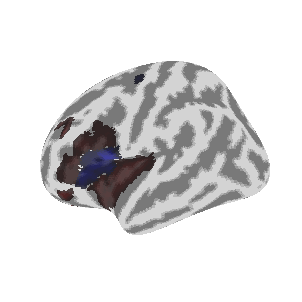

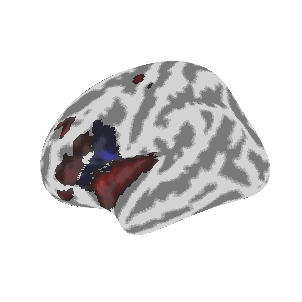

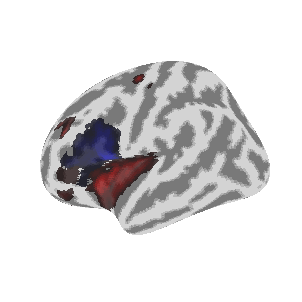

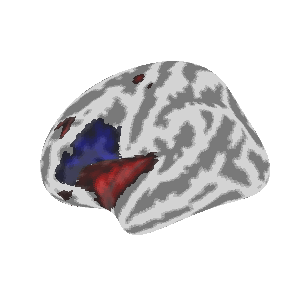

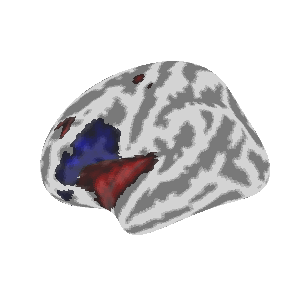

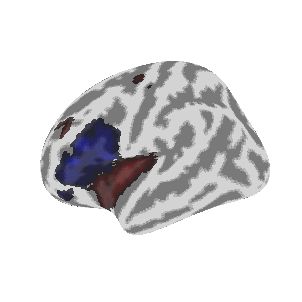

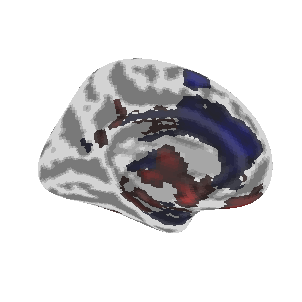

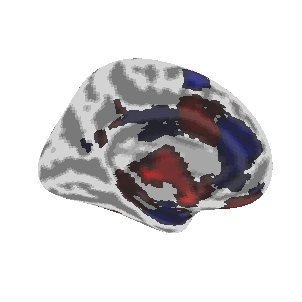

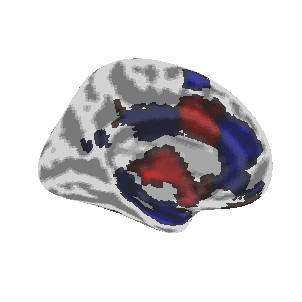

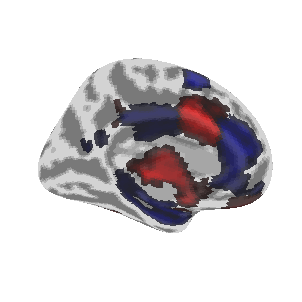

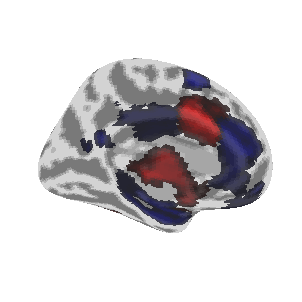

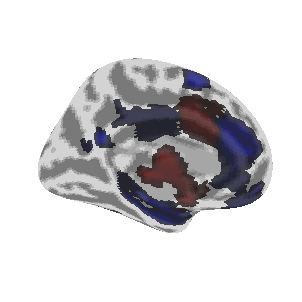

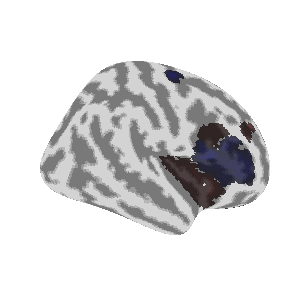

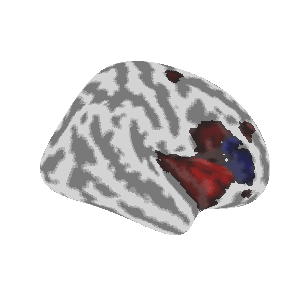

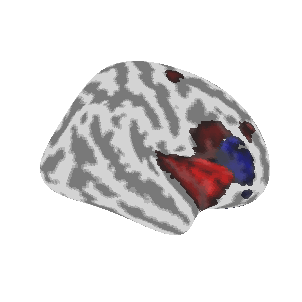

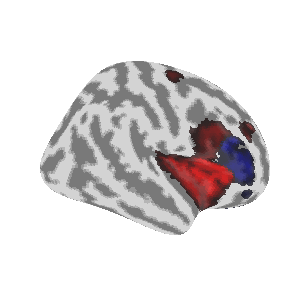

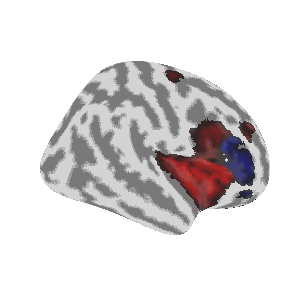

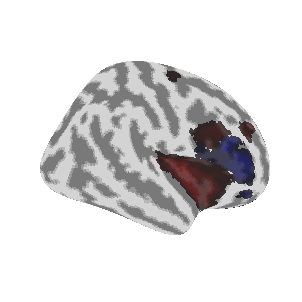

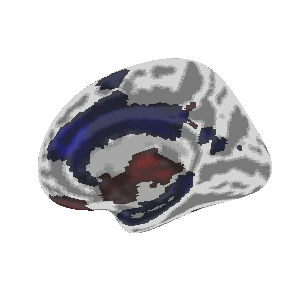

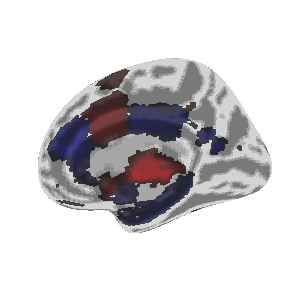

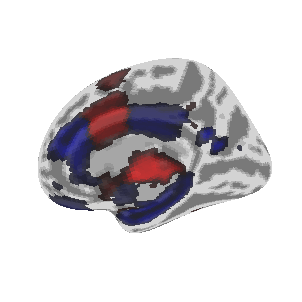

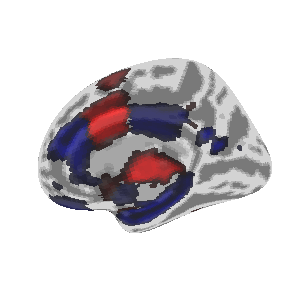

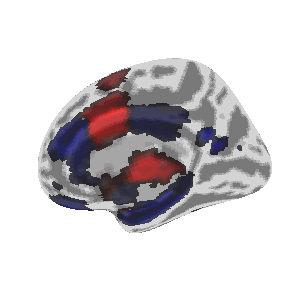

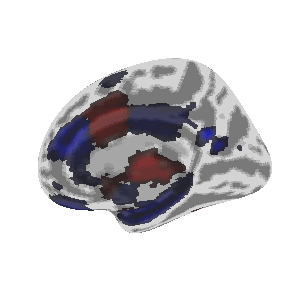

In [21]:
for idx_state in [4]:
    for hemi in ["left","right"]:
        for view in ["lateral","medial"]:
            # dur = int(np.median([y.shape[0] for y in state_resps[idx_state]]))
            # mean_resps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
            mean_resps = mean_imps_all_states[idx_state]
            dur = mean_resps.shape[0]
            
            print(mean_resps.shape)
            for t in range(mean_resps.shape[0]):
                img = vec2img(mean_resps[t,:])
                # plot_stat_map(img)
                fig,ax = plot_img_on_surf(
                    stat_map=img,
                    views=[view],
                    hemispheres=[hemi],
                    colorbar=False,
                    inflate=True,
                    threshold=0.001,
                    vmax=0.5,#np.abs(mean_resps).max(),
                    # title=f'state{idx_state+1} t={t}',
                    bg_on_data=True,
                )
                fig.savefig(f'./roi_importance/state{idx_state+1}_t={t+1}_all_terms_{hemi}_{view}.png',dpi=300,bbox_inches='tight',facecolor=None, transparent=True)

(6, 85)
(6, 85)
(6, 85)
(6, 85)


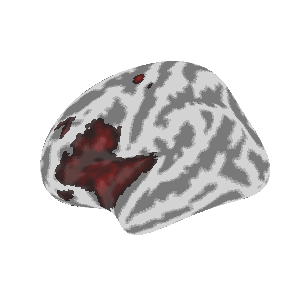

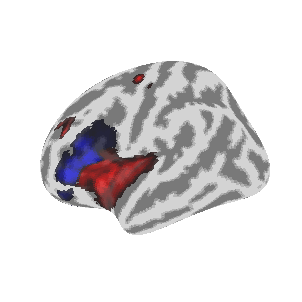

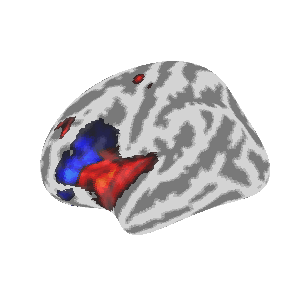

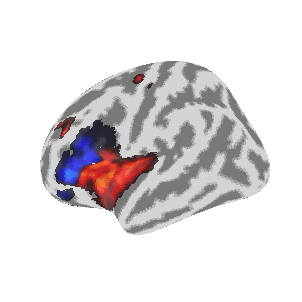

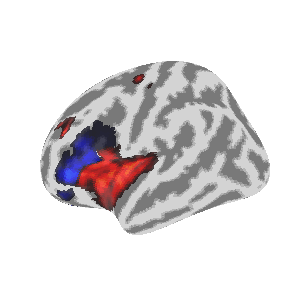

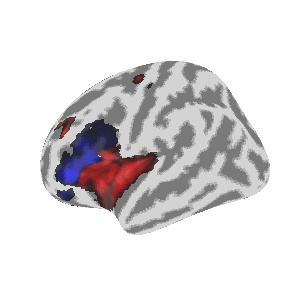

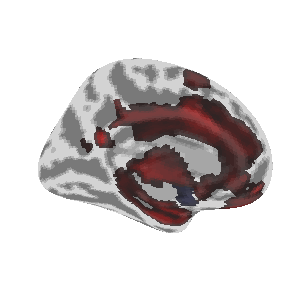

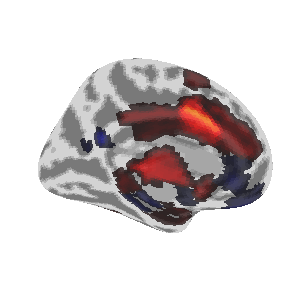

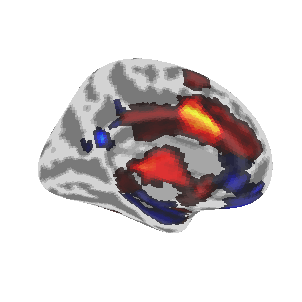

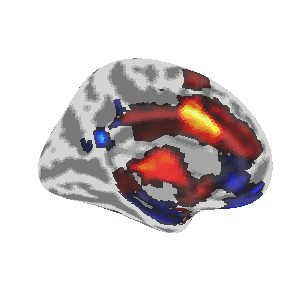

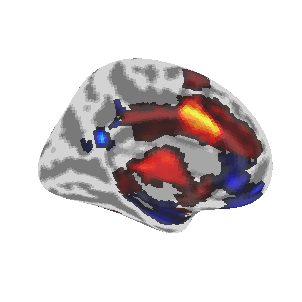

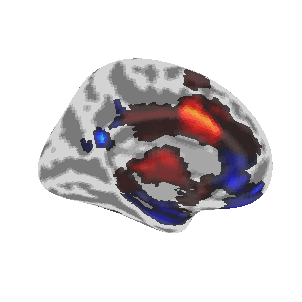

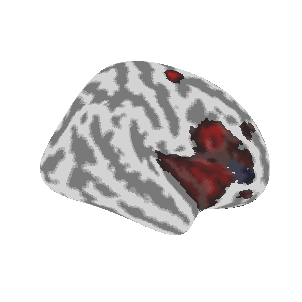

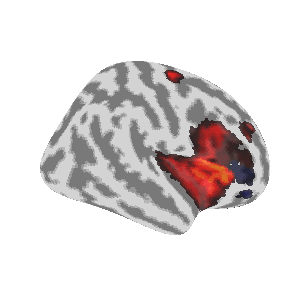

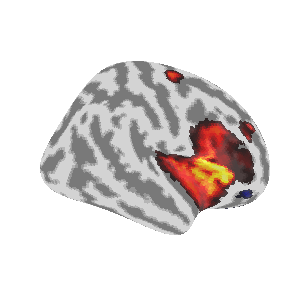

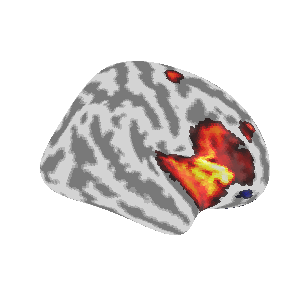

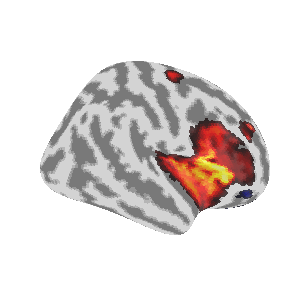

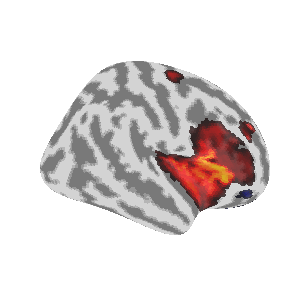

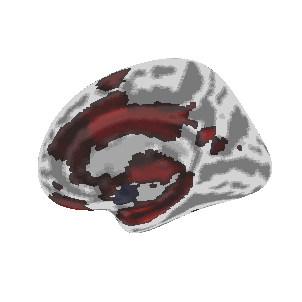

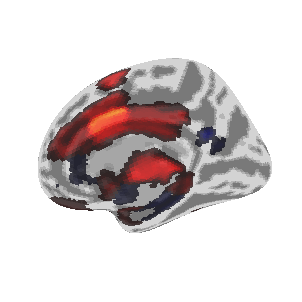

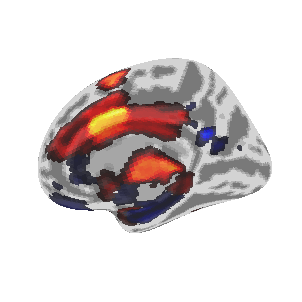

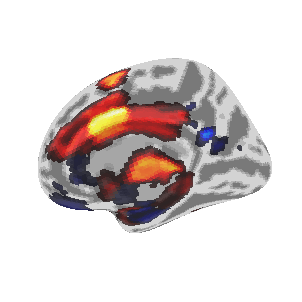

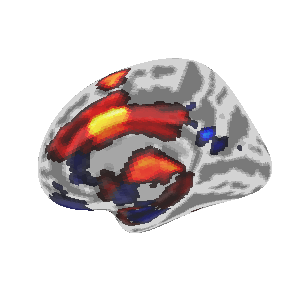

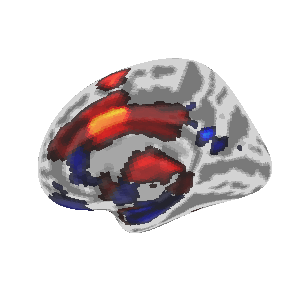

In [83]:
for idx_state in [4]:
    for hemi in ["left","right"]:
        for view in ["lateral","medial"]:
            # dur = int(np.median([y.shape[0] for y in state_resps[idx_state]]))
            # mean_resps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
            mean_resps = mean_bold_all_states[idx_state]
            dur = mean_resps.shape[0]
            
            print(mean_resps.shape)
            for t in range(mean_resps.shape[0]):
                img = vec2img(mean_resps[t,:])
                # plot_stat_map(img)
                fig,ax = plot_img_on_surf(
                    stat_map=img,
                    views=[view],
                    hemispheres=[hemi],
                    colorbar=False,
                    inflate=True,
                    threshold=0.001,
                    vmax=np.abs(mean_resps).max(),
                    # title=f'state{idx_state+1} t={t}',
                    bg_on_data=True,
                )
                fig.savefig(f'./roi_importance/state{idx_state+1}_t={t+1}_bold_{hemi}_{view}.png',dpi=300,bbox_inches='tight',facecolor='white', transparent=False)

In [16]:
def ts2img(ts:np.ndarray):
    atlasimg = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
    atlasdata = atlasimg.get_fdata()
    vols = []
    for t in range(ts.shape[0]):
        vec = ts[t,:]
        nrois = vec.shape[0]
        retdata = np.zeros_like(atlasdata)
        for idx_roi in range(nrois):
            retdata[atlasdata==(idx_roi+1)] = vec[idx_roi]
        vols.append(retdata)
    vols = np.stack(vols,axis=-1)
    ret = new_img_like(ref_niimg=atlasimg,data=vols)
    return ret

for idx_state in range(K-1):
    dur = int(np.median([y.shape[0] for y in state_resps[idx_state]]))
    mean_resps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
    img = ts2img(mean_resps)
    img.to_filename(f'roi_importance/roi_importance_state{idx_state+1}.nii.gz')

In [15]:
def ts2img(ts:np.ndarray):
    atlasimg = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
    atlasdata = atlasimg.get_fdata()
    vols = []
    for t in range(ts.shape[0]):
        vec = ts[t,:]
        nrois = vec.shape[0]
        retdata = np.zeros_like(atlasdata)
        for idx_roi in range(nrois):
            retdata[atlasdata==(idx_roi+1)] = vec[idx_roi]
        vols.append(retdata)
    vols = np.stack(vols,axis=-1)
    ret = new_img_like(ref_niimg=atlasimg,data=vols,copy_header=True)
    return ret

for idx_state in range(K-1):
    mean_bold = mean_bold_all_states[idx_state]
    dur = mean_imps.shape[0]
    img = ts2img(mean_bold)
    img.to_filename(f'roi_importance/roi_bold_state{idx_state+1}.nii.gz')